In [145]:
import geopandas as gpd
import pandas as pd
import os.path
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import itertools
from itertools import compress

In [146]:
# def check_intersections(edges, edge_id_col, return_edges=True):

#     '''
#     Detects topological errors in gdf with edges from OSM data.
#     If two edges are intersecting (i.e. no node at intersection) and neither is tagged as a bridge or a tunnel,
#     it is considered an error in the data.

#     Arguments:
#         gdf (gdf): gdf with edges to check for missing intersection nodes
#         edge_id_col (str): name of column with unique edge_id
#         return_edges (boolean): if True, also return the edges identified as missing a node 

#     Returns:
#         intersection_issues (list): list with tuples with ids of edges missing an intersection node between them
#         edges_inter (gdf): geodataframe with edges missing an intersection node
#     '''

#     edges_subset = edges.loc[~(edges.tunnel.isin(['yes','Yes',True,'passage','building_passage','movable']) | edges.bridge.isin(['yes','Yes',True,'passage','building_passage','movable']) )]

#     overlay_edges = edges_subset.overlay(edges_subset, how='intersection', keep_geom_type=False)

#     edge_id_1 = edge_id_col+'_1'
#     edge_id_2 = edge_id_col+'_2'

#     overlay_selection = overlay_edges.loc[overlay_edges[edge_id_1] != overlay_edges[edge_id_2]]

#     if len(overlay_selection) > 0:

#         all_intersections = list(zip(overlay_selection[edge_id_1], overlay_selection[edge_id_2]))
#         all_intersections = [set(a) for a in all_intersections]
        
#         # Remove duplicaties
#         unique_intersections = [set(item) for item in set(frozenset(item) for item in all_intersections)]

#         unique_intersections = [tuple(a) for a in unique_intersections]

#         # These also include edges that touch due to sharing a node
#         # We therefore check if they actually cross
#         intersection_issues = []

#         for u in unique_intersections:

#             e1 = edges.loc[edges[edge_id_col]==u[0]]
#             e2 = edges.loc[edges[edge_id_col]==u[1]]

#             if e1.crosses(e2.geometry, align=False).values[0] == True:
#                 intersection_issues.append(u)

#         if len(intersection_issues) > 0:

#             if return_edges:

#                 ids = list(itertools.chain(*intersection_issues))
#                 edges_inter = edges.loc[edges[edge_id_col].isin(ids)]

#                 return intersection_issues, edges_inter

#             else:
#                 return intersection_issues

#         else:
#             print('No missing intersection nodes found')



# def edges_crossing(id_tuple, edge_id_col):

#     '''
#     Detect whether the geometries of two edges crosses

#     Arguments:
#         id_tuple (tuple): the ids of the edges to be checked for crossing geometries
#         edge_id_col (str): the name of the column with unique edge id

#     Returns:
#         crossing (boolean): True if they cross, otherwise False

#     '''

#     e1 = edges.loc[edges[edge_id_col]==id_tuple[0]]
#     e2 = edges.loc[edges[edge_id_col]==id_tuple[1]]

#     crossing = e1.crosses(e2.geometry, align=False).values[0]

#     return crossing
    

# # def check_intersections_2(edges, edge_id_col, return_edges=True):

# #     '''
# #     Detects topological errors in gdf with edges from OSM data.
# #     If two edges are intersecting (i.e. no node at intersection) and neither is tagged as a bridge or a tunnel,
# #     it is considered an error in the data.

# #     Arguments:
# #         gdf (gdf): gdf with edges to check for missing intersection nodes
# #         edge_id_col (str): name of column with unique edge_id
# #         return_edges (boolean): if True, also return the edges identified as missing a node 

# #     Returns:
# #         intersection_issues (list): list with tuples with ids of edges missing an intersection node between them
# #         edges_inter (gdf): geodataframe with edges missing an intersection node
# #     '''

# #     edges_subset = edges.loc[~(edges.tunnel.isin(['yes','Yes',True,'passage','building_passage','movable']) | edges.bridge.isin(['yes','Yes',True,'passage','building_passage','movable']) )]

# #     overlay_edges = edges_subset.overlay(edges_subset, how='intersection', keep_geom_type=False)

# #     edge_id_1 = edge_id_col+'_1'
# #     edge_id_2 = edge_id_col+'_2'

# #     overlay_selection = overlay_edges.loc[overlay_edges[edge_id_1] != overlay_edges[edge_id_2]]

   
# #     if len(overlay_selection) > 0:

# #         all_intersections = list(zip(overlay_selection[edge_id_1], overlay_selection[edge_id_2]))
# #         all_intersections = [set(a) for a in all_intersections]


# #         # Remove duplicaties
# #         unique_intersections = [set(item) for item in set(frozenset(item) for item in all_intersections)]

# #         unique_intersections = [tuple(a) for a in unique_intersections]

# #         # These also include edges that touch due to sharing a node
# #         # We therefore check if they actually cross
# #         intersection_issue_filter = [edges_crossing(u, edge_id_col) for u in unique_intersections]

# #         intersection_issues = list(compress(unique_intersections, intersection_issue_filter))

# #         if len(intersection_issues) > 0:

# #             if return_edges:

# #                 ids = list(itertools.chain(*intersection_issues))
# #                 edges_inter = edges.loc[edges[edge_id_col].isin(ids)]

# #                 return intersection_issues, edges_inter

#         #     else:
#         #         return intersection_issues

#         # else:
#         #     print('No missing intersection nodes found')
            
#         #     return (0,0)


def check_crossing(row, gdf):

    '''
    Detects whether a row from a gdf with line geomtries intersects with any of the geometries in a gdf

    Arguments:
        row (row): row currently analysed
        gdf (gdf): gdf with other edges/geometries to check for intersections iwth

    Returns:
        count (int): number of intersection issues for each row
    '''

    intersection = gdf[gdf.crosses(row.geometry)]

    intersection_issues_count = len(intersection)

    return intersection_issues_count
        

def find_missing_intersections(edges, edge_id_col, return_edges=True):

    '''
    Detects topological errors in gdf with edges from OSM data.
    If two edges are intersecting (i.e. no node at intersection) and neither is tagged as a bridge or a tunnel,
    it is considered an error in the data.
    '''

    # Don't include tunnels or bridges
    edges_subset = edges.loc[~(edges.tunnel.isin(['yes','Yes',True,'passage','building_passage','movable']) | edges.bridge.isin(['yes','Yes',True,'passage','building_passage','movable']) )].copy()

    edges_subset['intersection_issues'] = edges_subset.apply(lambda x: check_crossing(row = x, gdf=edges_subset), axis=1)

    missing_nodes = list(edges_subset.loc[(edges_subset.intersection_issues.notna()) & edges_subset.intersection_issues > 0][edge_id_col].values)

    edges_missing_node = edges_subset.loc[(edges_subset.intersection_issues.notna()) & edges_subset.intersection_issues > 0]

    
    if return_edges:
        return missing_nodes, edges_missing_node

    else:
        return missing_nodes


# Test find_missing_intersection
l1 = LineString([[1,1],[11,11]])
l2 = LineString([[2,1],[6,10]])
l3 = LineString([[10,10],[10,20]])
l4 = LineString([[11,9],[5,20]])
l5 = LineString([[1,12],[4,12]])
l6 = LineString([[6,20],[10,20]])

lines = [l1, l2, l3,l4,l5, l6]
d = {'id':[1,2,3,4,5,6],'bridge':['yes','no', None,'no',None,'no'],'tunnel':['no','no',None,None,None,None], 'geometry':lines }
edges = gpd.GeoDataFrame(d)

missing_nodes_edge_ids, edges_with_missing_nodes = find_missing_intersections(edges, 'id')

assert len(missing_nodes_edge_ids) == 2
assert missing_nodes_edge_ids == [3,4] or missing_nodes_edge_ids == [4,3]
assert len(edges_with_missing_nodes) == 2
assert edges_with_missing_nodes.id.to_list() == [3,4]

# edges['intersection_issues'] = edges.apply(lambda x: check_crossing(row = x, gdf=edges), axis=1)

# count_intersection_issues = len(edges.loc[(edges.intersection_issues.notna()) & edges.intersection_issues > 0])

# assert count_intersection_issues == 2
# assert edges.loc[2,'intersection_issues'] == 1
# assert edges.loc[3,'intersection_issues'] == 2

# missing_nodes, edges_with_missing_nodes = check_intersections(edges, 'id')

# assert len(missing_nodes) == 1
# assert len(missing_nodes[0]) == 2
# assert missing_nodes[0] == (3,4) or missing_nodes[0] == (4,3)
# assert len(edges_with_missing_nodes) == 2
# assert edges_with_missing_nodes.id.to_list() == [3,4]

# # missing_nodes, edges_with_missing_nodes = check_intersections_2(edges, 'id')

# # assert len(missing_nodes) == 1
# # assert len(missing_nodes[0]) == 2
# # assert missing_nodes[0] == (3,4) or missing_nodes[0] == (4,3)
# # assert len(edges_with_missing_nodes) == 2
# # assert edges_with_missing_nodes.id.to_list() == [3,4]



<AxesSubplot:>

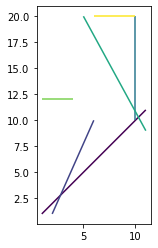

In [147]:
edges.plot(column='id')

<AxesSubplot:>

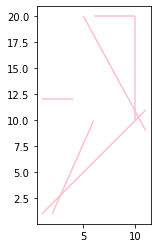

In [148]:
edges.plot(color='pink')

In [71]:
%run ../settings/yaml_variables.py
%run ../settings/plotdict.py
%run ../settings/tiledict.py
%run ../settings/load_osmdata.py
%run ../settings/df_styler.py

OSM graphs loaded successfully!
OSM data loaded successfully!


In [117]:
edges_subset = osm_edges.loc[~(osm_edges.tunnel.isin(['yes','Yes',True,'passage','building_passage','movable']) | osm_edges.bridge.isin(['yes','Yes',True,'passage','building_passage','movable']) )].copy()

edges_subset['intersection_issues'] = edges_subset.apply(lambda x: check_intersections_new(row = x, gdf=edges_subset), axis=1)

count_intersection_issues = len(edges_subset.loc[(edges_subset.intersection_issues.notna()) & edges_subset.intersection_issues > 0])/2 # The number of issues is counted twice since both intersecting osm_edges are returned

print(f'{count_intersection_issues:.0f} place(s) appear to be missing an intersection node or a bridge/tunnel tag.')

1 place(s) appear to be missing an intersection node or a bridge/tunnel tag.


In [142]:
m, t = find_missing_intersections(osm_edges,'edge_id')


In [144]:
m

[36931, 49725]